In [1]:
import os
import time
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz
%matplotlib inline

In [5]:
root_dataset = "/var/scratch/lvs215/processed-surf-dataset/"

In [3]:
# Count the number of physical cores in LISA so that we can compare it with the summed load1 metric across all nodes.
# Based on https://userinfo.surfsara.nl/systems/lisa/description accessed on 2020-10-08
number_of_cores_in_lisa = 0
number_of_cores_in_lisa += 23  * 6  # Intel® Xeon® Bronze 3104 Processor 
number_of_cores_in_lisa += 2   * 6  # Intel® Xeon® Bronze 3104 Processor 
number_of_cores_in_lisa += 29  * 12 # Intel® Xeon® Gold 5118 Processor 
number_of_cores_in_lisa += 192 * 16 # Intel® Xeon® Gold 6130 Processor 
number_of_cores_in_lisa += 96  * 8  # Intel® Xeon® Silver 4110 Processor 
number_of_cores_in_lisa += 1   * 12 # Intel® Xeon® Gold 6126 Processor 

In [6]:
# Perform the load1 computation
load1_df = pd.read_parquet(os.path.join(root_dataset, "node_load1"))
load1_df.replace(-1.0, 0, inplace=True) # Make sure we set "invalid values" to 0 to avoid influencing the sum
load1_df = load1_df.sum(axis=1, skipna=True) # Sum the values across the columns (axis = 1), so we get per timestamp the total load1 across LISA

load1_df = load1_df / number_of_cores_in_lisa
load1_df.clip(upper=1.0, inplace=True)  # Clip values above the number of cores to 1 ()
load1_df.max()

1.0

In [7]:
max_tempature_allowed =  77  # based on https://ark.intel.com/content/www/us/en/ark/products/123547/intel-xeon-silver-4110-processor-11m-cache-2-10-ghz.html which has the lowest T_CASE across all

# Perform the ambient temperature computation
rack_temp = pd.read_parquet(os.path.join(root_dataset, "surfsara_ambient_temp"))
rack_temp.replace(-1.0, np.nan, inplace=True)  # Set -1 values which are invalid to NaNs so we can omit them.
rack_temp = rack_temp.mean(axis=1, skipna=True)  # Compute the mean, skip NaNs
rack_temp.dropna(how='all', inplace=True)  # For safety: drop timestamps that had 0 valid values.
rack_temp = rack_temp / max_tempature_allowed
rack_temp.clip(upper=1.0, inplace=True)  # Clip values above 1 with respect to max_tempature_allowed
rack_temp.max()

0.33402266523285634

In [9]:
# LISA has two types of GPUs:
# GeForce 1080Ti and Titan V. Both have the Thermal Threshold of 91 degree Celcius.
# https://www.nvidia.com/en-sg/geforce/products/10series/geforce-gtx-1080-ti/
# https://www.nvidia.com/en-us/titan/titan-v/
max_gpu_tempature_allowed =  91

# Perform the ambient temperature computation
gpu_temp = pd.read_parquet(os.path.join(root_dataset, "nvidia_gpu_temperature_celsius"))
gpu_temp.replace(-1.0, np.nan, inplace=True)  # Set -1 values which are invalid to NaNs so we can omit them.
gpu_temp = gpu_temp.mean(axis=1, skipna=True)  # Compute the mean, skip NaNs
gpu_temp.dropna(how='all', inplace=True)  # For safety: drop timestamps that had 0 valid values.
gpu_temp = gpu_temp / max_gpu_tempature_allowed
gpu_temp.clip(upper=1.0, inplace=True)  # Clip values above 1 with respect to max_tempature_allowed

In [10]:
# The average power consumption throught the datacenter.
# The cooling for all the racks is the same, with a capability of max 5500 Watts

cluster_power_df = pd.read_parquet(os.path.join(root_dataset, "surfsara_power_usage"))

cluster_power_df.replace(-1.0, np.nan, inplace=True)  # Set -1 values which are invalid to NaNs so we can omit them.

# Drop columns that only have NaN values, we need to drop them because they will add to max_allowed_power_consumption but do not contribute in the sum.
cluster_power_df.dropna(how='all', axis=1, inplace=True) 
cluster_power_df.dropna(how='all', inplace=True)  # For safety: drop timestamps that had 0 valid values.

max_allowed_power_consumption = 5500 * cluster_power_df.shape[1]

cluster_power_df = cluster_power_df.sum(axis=1, skipna=True)  # Compute the mean, skip NaNs
cluster_power_df = cluster_power_df / max_allowed_power_consumption
cluster_power_df.clip(upper=1.0, inplace=True)  # Clip values above 1 with respect to max_tempature_allowed
cluster_power_df.max()

0.03947936507936508

In [11]:
# RAM usage computation.
memory_total = pd.read_parquet(os.path.join(root_dataset, "node_memory_MemTotal"))
memory_free = pd.read_parquet(os.path.join(root_dataset, "node_memory_MemFree"))

# Align the two dataframes, use inner so that all mismatched between columns and timestmaps are dropped.
# Axis = none aligns on both index AND columns, which is what we want.
memory_total, memory_free = memory_total.align(memory_free, join="inner", axis=None)

# We can now devide safely because all indices and columns are aligned.
memory_df = memory_free / memory_total
del memory_total, memory_free # Free up RAM during computation

# Switch to memory_consumed rather than free
memory_df = 1 - memory_df

# Compute the average
memory_df = memory_df.mean(axis=1, skipna=True)
print(memory_df)

1577685615    0.137794
1577685630    0.145134
1577685645    0.145976
1577685660    0.145503
1577685675    0.145419
                ...   
1589925525    0.138196
1589925540    0.138075
1589925555    0.137709
1589925570    0.137474
1589925585    0.137419
Length: 804719, dtype: float64


In [12]:
# GPU fan speed computation
max_fanspeed =  100  # It's percentage based 

gpu_fanspeed_df = pd.read_parquet(os.path.join(root_dataset, "nvidia_gpu_fanspeed_percent"))
gpu_fanspeed_df.replace(-1.0, np.nan, inplace=True)  # Set -1 values which are invalid to NaNs so we can omit them.
gpu_fanspeed_df = gpu_fanspeed_df.mean(axis=1, skipna=True)  # Compute the mean, skip NaNs
gpu_fanspeed_df.dropna(how='all', inplace=True)  # For safety: drop timestamps that had 0 valid values.
gpu_fanspeed_df = gpu_fanspeed_df / max_fanspeed
gpu_fanspeed_df.max()

0.5461344537815126

In [ ]:
# GPU memory computation
gpu_memory_df = pd.read_parquet(os.path.join(root_dataset, "nvidia_gpu_memory_used_bytes"))

for column in gpu_memory_df.columns:
    gpu_name = column[1]
    if "GeForce GTX 1080 Ti" in gpu_name:
        GPU_GB = 11
    elif "TITAN V" in gpu_name:
        GPU_GB = 12
    elif "TITAN RTX" in gpu_name:
        GPU_GB = 24
    else:
        print(gpu_name)
        GPU_GB = 0  # Make it crash - unknown GPU type
    gpu_memory_df[column] = gpu_memory_df[column] / (GPU_GB * 1024 * 1024 * 1024)

gpu_memory_df.dropna(how='all', inplace=True)  # For safety: drop timestamps that had 0 valid values.
gpu_memory_df = gpu_memory_df.mean(axis=1, skipna=True)  # Compute the mean across the entire cluster for all nodes,gpu pairs
gpu_memory_df.max()

In [14]:
# DISK IO

# For this, we are summing up the node_disk_bytes_read values and the node_disk_bytes_written
bytes_read_df = pd.read_parquet(os.path.join(root_dataset, "node_disk_bytes_read"))
bytes_read_df.replace(-1.0, np.nan, inplace=True)

# Compute the time since the last timestamp, in case there are gaps in the index.
time_between_indices = bytes_read_df.index.to_series().diff().dropna()

# Drop columns with no recorded values
bytes_read_df.dropna(how='all', axis=1, inplace=True)

# As the values are incremental, we have totake the difference between the row and the previous
bytes_read_df = bytes_read_df.diff()

# Drop rows with only NA values
bytes_read_df.dropna(how='all', inplace=True)  # The first row will be N/A because we do not know how many bytes were writting on that timestamp, there may be others.

# Convert the bytes_read to values per second
bytes_read_df = bytes_read_df.div(time_between_indices, axis=0)
print(bytes_read_df.max().max())

# We apply the same to bytes_written
bytes_written_df = pd.read_parquet(os.path.join(root_dataset, "node_disk_bytes_written"))
bytes_written_df.replace(-1.0, np.nan, inplace=True)

# Compute the time since the last timestamp, in case there are gaps.
time_between_indices = bytes_written_df.index.to_series().diff().dropna()

# Drop columns with no recorded values
bytes_written_df.dropna(how='all', axis=1, inplace=True) 
bytes_written_df = bytes_written_df.diff()
bytes_written_df.dropna(how='all', inplace=True)
bytes_written_df = bytes_written_df.div(time_between_indices, axis=0)
print(bytes_written_df.max().max())

del time_between_indices

# Align the two dataframes on index and columns (for safety) so we can safely sum!
bytes_read_df, bytes_written_df = bytes_read_df.align(bytes_written_df, join="inner", axis=None)

# Sum them up!
disk_io_df = bytes_read_df + bytes_written_df
del bytes_read_df, bytes_written_df  # Free up RAM

print(disk_io_df.max().max())

# Compute how much IO we can expect, assuming that all the nodes have a disk that we investigate
max_disk_io = 1.8 * disk_io_df.shape[1] * 1000 * 1000 * 1000
disk_io_df = disk_io_df.sum(axis=1, skipna=True) # Sum the values across the columns (axis = 1), so we get per timestamp the total load1 across LISA
disk_io_df = disk_io_df / max_disk_io # Get the fractions, and we're done!

disk_io_df.clip(upper=1.0, inplace=True)  # Clip values above the number of cores to 1 ()

disk_io_df.max()

1387104665.6
867582939511.4667
867583387852.8


1.0

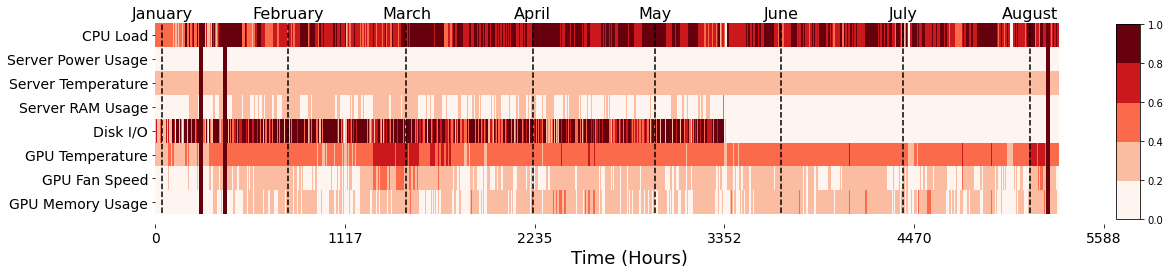

In [63]:
# Construct the overview figure

series_to_use = [
    (load1_df, "CPU Load"),
    (cluster_power_df, "Server Power Usage"),
    (rack_temp, "Server Temperature"),
    (memory_df, "Server RAM Usage"),
    (disk_io_df, "Disk I/O"),
    (gpu_temp, "GPU Temperature"),
    (gpu_fanspeed_df, "GPU Fan Speed"),
    (gpu_memory_df, "GPU Memory Usage"),
]

df = None

for ser, name in series_to_use:
    ser.name = name
    if df is None:
        df = ser.to_frame()
    else:
        df = df.merge(ser, how='outer', left_index=True, right_index=True)
    #del ser  # Free up RAM

# Safety, make sure the timestamps are in order
df.sort_index(inplace=True)

# Important! Get the start now, because we are going to apply a window and that the right side (end)
start = df.index[0]

# df.dropna(how='all', axis='index', inplace=True)  # Drop rows with only NaNs  - this will remove gaps but ma
df.fillna(0.0, inplace=True) # Fill in others with 0 so they show up as not significant at least

# Convert the index to a date so we can resample using a 1 hour window.
df["dt"] = pd.to_datetime(df.index, utc=True, unit="s")
df["dt"] = df["dt"].dt.tz_convert(pytz.timezone('Europe/Amsterdam')).dt.tz_localize(None)
df = df.set_index("dt")
df = df.resample('1H', label='right').max()  # For each hour, get the maximum
df.index = df.index.astype(np.int64) // 10**9  # Convert back to unix timestamp so we can modify the plot axis later

cmap = plt.cm.get_cmap('Reds')
# cNorm = plt.cm.colors.Normalize(vmin=0, vmax=1)  # Use this one if you want a linear gradient
cNorm = mpl.colors.BoundaryNorm(np.linspace(0, 1, 6), cmap.N)  # Use this one if you want a discrete gradient
scalarMap = plt.cm.ScalarMappable(norm=cNorm, cmap=cmap)


fig, ax = plt.subplots(figsize=(17, 4))
ax.invert_yaxis()
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
ax.set_xlabel("Time (Hours)", fontsize=18)

#https://stackoverflow.com/questions/14908576/how-to-remove-frame-from-matplotlib-pyplot-figure-vs-matplotlib-figure-frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

left = 0
for index, row in df.iterrows():  # Iterate over all the rows
    width = index - (start+left)  # Get how wide this piece should be, based on the previous value (timestamp) to account for big gaps
    lefts = [left] * len(df.columns)  # For all values, set the offset
    colors = row.apply(scalarMap.to_rgba)  # Compute the colors for this particular slice
    ax.barh(df.columns, width=width, left=lefts, height=1.0, linewidth=0, label=df.columns, color=colors)
    left += width  # update left

def get_converted_xticks(ax):
    """
    :param ax:
    :return list of day and month strings
    """
    # return [pd.to_datetime(start + tick, unit='s').date().strftime("%d\n%b") for tick in ax.get_xticks()]
    return [int((tick) / 3600) for tick in ax.get_xticks()]  # Get the hour number

ax.set_xticks(np.linspace(0, ax.get_xlim()[1], num=6, dtype=int))  # Make sure we include 0 and the last value in the plot, so set the xticks ourselves
ax.set_xticklabels(get_converted_xticks(ax))


# Draw a line at the start of each month + annotate the date
first_line = pd.to_datetime(df.index[0], unit='s').date()
cur_year = first_line.year
cur_month = first_line.month
cur_month += 1
if cur_month == 13:
    cur_month = 1
    cur_year += 1
start_next_month = time.mktime(datetime(cur_year, cur_month, 1).timetuple())
while start_next_month <= df.index[-1]:
    ax.axvline(start_next_month - start, ymin=0.05, ymax=0.95, color='black', linestyle='dashed')  # seems we have some margin due to hbars?
    ax.text(x=start_next_month - start, y=-0.7, s=datetime(cur_year, cur_month, 1).strftime("%B"), fontsize=16, ha="center")
    cur_month += 1
    if cur_month == 13:
        cur_month = 1
        cur_year += 1
    start_next_month = time.mktime(datetime(cur_year, cur_month, 1).timetuple())

# Based on https://stackoverflow.com/a/39938019 and https://stackoverflow.com/a/39938019
pos = ax.get_position()
pad = 0.01
width = 0.02
ax2 = fig.add_axes([pos.xmax + pad, pos.ymin + 0.04, width, 0.9 * (pos.ymax - pos.ymin)])  # x, y, width, height
fig.colorbar(scalarMap, cax=ax2)
fig.subplots_adjust(bottom=0.15)

date_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
# fig.savefig(f"generic_bottleneck_surf_{date_time}.pdf", bbox_inches = "tight")
fig.savefig(f"generic_bottleneck_surf_{date_time}.png", bbox_inches = "tight")